In [1]:
# Importação das bibliotecas necessárias
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences



In [2]:
import requests
url = 'https://fiapdatasets.blob.core.windows.net/deeplearning/morte_vida_severina.txt'


response = requests.get(url)
file_Path = 'morte_vida_severina.txt'

if response.status_code == 200:
    with open(file_Path, 'wb') as file:
        file.write(response.content)
    print('Download com Sucesso')
else:
    print('Falha no Download')

Download com Sucesso


In [3]:
# Carregar o texto do arquivo e transformar tudo para minúsculas para manter uniformidade
with open("morte_vida_severina.txt", "r", encoding='utf-8') as file:
    text = file.read().lower()
print(text)

— o meu nome é severino,
como não tenho outro de pia.
como há muitos severinos,
que é santo de romaria,
deram então de me chamar
severino de maria;
como há muitos severinos
com mães chamadas maria,
fiquei sendo o da maria
do finado zacarias.
mais isso ainda diz pouco:
há muitos na freguesia,
por causa de um coronel
que se chamou zacarias
e que foi o mais antigo
senhor desta sesmaria.
como então dizer quem falo
ora a vossas senhorias?
vejamos: é o severino
da maria do zacarias,
lá da serra da costela,
limites da paraíba.
mas isso ainda diz pouco:
se ao menos mais cinco havia
com nome de severino
filhos de tantas marias
mulheres de outros tantos,
já finados, zacarias,
vivendo na mesma serra
magra e ossuda em que eu vivia.
somos muitos severinos
iguais em tudo na vida:
na mesma cabeça grande
que a custo é que se equilibra,
no mesmo ventre crescido
sobre as mesmas pernas finas
e iguais também porque o sangue,
que usamos tem pouca tinta.
e se somos severinos
iguais em tudo na vida,
morremos

In [4]:
# Etapa 1: Tokenização
# Cria um Tokenizer para converter palavras em números, pois o modelo precisa de entradas numéricas
tokenizer = Tokenizer()
tokenizer.fit_on_texts([text])  # Adapta o tokenizer ao texto fornecido
total_words = len(tokenizer.word_index) + 1  # Contagem de palavras distintas (vocabulário)
print(total_words)

1538


In [5]:
# Mapeamento índice -> palavra
index_to_word = {index: word for word, index in tokenizer.word_index.items()}
print("Índice para Palavra:", index_to_word)

Índice para Palavra: {1: 'que', 2: 'de', 3: '—', 4: 'a', 5: 'o', 6: 'e', 7: 'é', 8: 'não', 9: 'se', 10: 'da', 11: 'mais', 12: 'em', 13: 'vida', 14: 'para', 15: 'como', 16: 'na', 17: 'do', 18: 'mas', 19: 'terra', 20: 'das', 21: 'me', 22: 'com', 23: 'almas', 24: 'os', 25: 'no', 26: 'aqui', 27: 'por', 28: 'dos', 29: 'um', 30: 'uma', 31: 'te', 32: 'há', 33: 'minha', 34: 'sua', 35: 'as', 36: 'morte', 37: 'gente', 38: 'onde', 39: 'foi', 40: 'ao', 41: 'também', 42: 'severino', 43: 'melhor', 44: 'ou', 45: 'agora', 46: 'bem', 47: 'quando', 48: 'diga', 49: 'ainda', 50: 'sempre', 51: 'irmãos', 52: 'nem', 53: 'seu', 54: 'lá', 55: 'já', 56: 'eu', 57: 'tem', 58: 'irmão', 59: 'só', 60: 'sei', 61: 'mar', 62: 'retirante', 63: 'rio', 64: 'coisa', 65: 'pouco', 66: 'dia', 67: 'ele', 68: 'água', 69: 'menos', 70: 'mesmo', 71: 'tal', 72: 'vejo', 73: 'será', 74: 'chão', 75: 'belo', 76: 'quem', 77: 'grande', 78: 'até', 79: 'essa', 80: 'tão', 81: 'sabe', 82: 'tua', 83: 'dizer', 84: 'tudo', 85: 'este', 86: 'são'

In [6]:
# Etapa 2: Criação de Sequências
# Constrói sequências para o treinamento do modelo usando o texto original
input_sequences = []
for line in text.split("\n"):  # Divide o texto em linhas
    token_list = tokenizer.texts_to_sequences([line])[0]  # Converte palavras em índices numéricos
    for i in range(1, len(token_list)):  # Cria n-gramas para capturar dependências sequenciais
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)  # Adiciona cada sequência à lista de entradas

# Imprime último n_gram_sequence
print(n_gram_sequence)


[2, 30, 13, 123]


O comando pad_sequences recebe uma lista de listas (onde cada sublista é uma sequência de tokens) e preenche essas listas para que todas tenham o mesmo comprimento. Ele faz isso adicionando um valor especificado (por padrão, 0) no início ou no fim de cada sequência.

Parâmetro padding

Um dos parâmetros principais é padding, que define onde o preenchimento (ou padding) ocorrerá na sequência. Ele pode ter dois valores:
 * padding='pre': Adiciona o padding no início da sequência. Esse é o comportamento padrão.
 * padding='post': Adiciona o padding no final da sequência.


In [7]:
# Etapa 3: Padding e Criação dos rótulos (y)
# Ajusta todas as sequências para um comprimento fixo
max_sequence_len = max([len(x) for x in input_sequences])  # Encontra a sequência mais longa
print(max_sequence_len)
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')

10


In [8]:
input_sequences[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 3, 5], dtype=int32)

In [9]:
# Separa os dados em X (entrada) e y (saída)
X, y = input_sequences[:,:-1], input_sequences[:,-1]  # Última palavra de cada sequência será a etiqueta
y = to_categorical(y, num_classes=total_words)  # Converte y para one-hot encoding

print(X[100])
print(y[100])
print(y.shape)

[  0   0   0   0   0   0 585   6 586]
[0. 0. 0. ... 0. 0. 0.]
(4590, 1538)


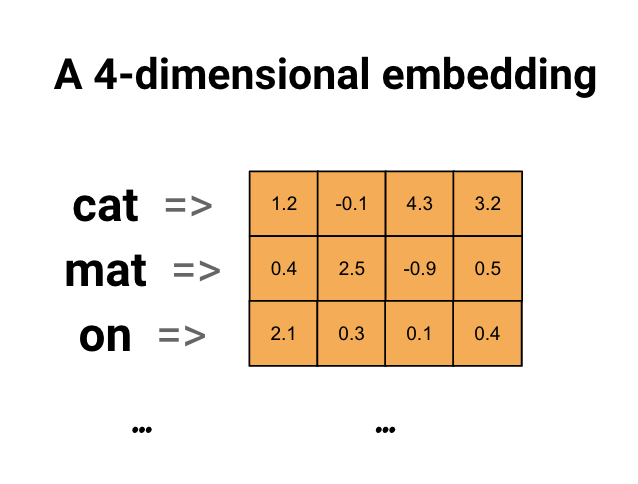

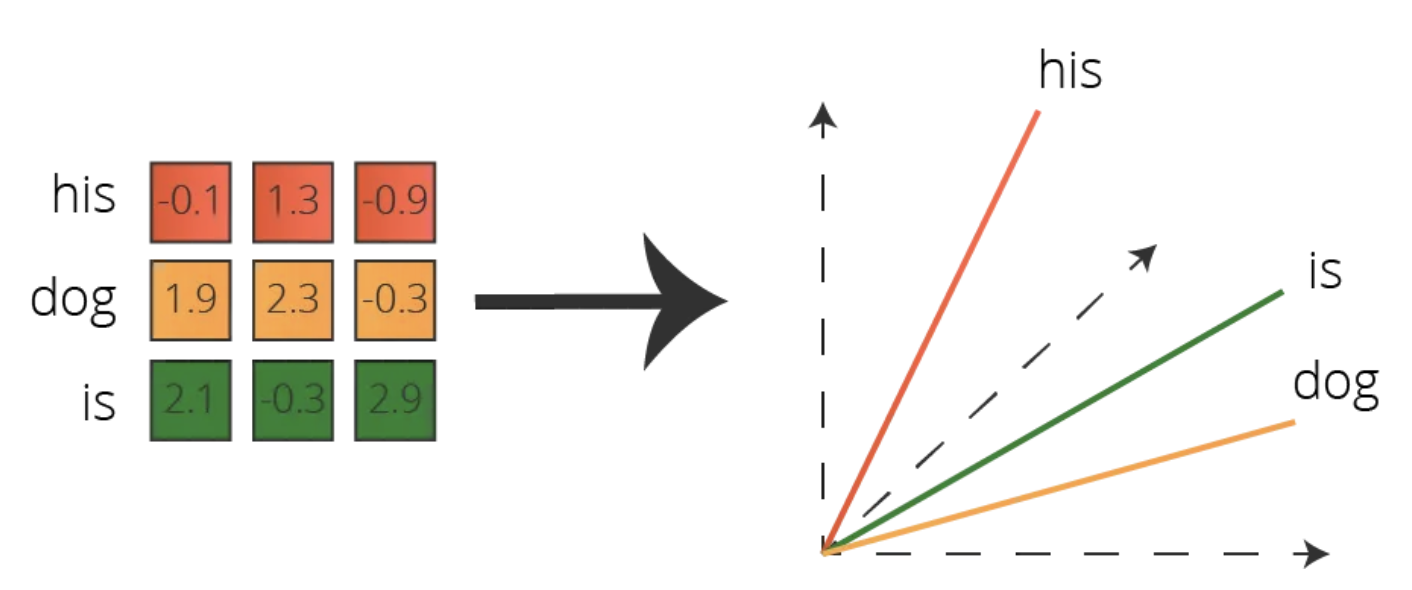

In [10]:
# Etapa 4: Construção do Modelo
# Define o modelo LSTM com camadas para gerar texto
model = Sequential()
# Camada Embedding para mapear palavras para vetores
#O parâmetro 32 na camada Embedding define a dimensão do vetor de embedding para cada palavra. Isso significa que cada palavra será representada como um vetor de 100 valores, ou seja, uma representação densa de 100 dimensões.
model.add(Embedding(input_dim=total_words, output_dim=32, input_length=max_sequence_len - 1))
model.add(LSTM(150, return_sequences=True))  # LSTM com 150 unidades, captura relações na sequência
model.add(Dropout(0.2))  # Dropout para evitar overfitting
model.add(LSTM(100))  # Outra camada LSTM
model.add(Dense(total_words, activation='softmax'))  # Camada densa com softmax para previsão de próxima palavra

# Compilação do modelo
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [11]:
# Treinamento do modelo
model.fit(X, y, epochs=300, verbose=1, batch_size =16)  # Treina por 300 épocas

Epoch 1/300
287/287 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.0338 - loss: 6.8041
Epoch 2/300
287/287 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.0396 - loss: 6.1525
Epoch 3/300
287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.0399 - loss: 6.1038
Epoch 4/300
287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.0462 - loss: 6.0179
Epoch 5/300
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.0559 - loss: 5.9210
Epoch 6/300
287/287 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.0698 - loss: 5.7670
Epoch 7/300
287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.0686 - loss: 5.7019
Epoch 8/300
287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.0675 - loss: 5.6281
Epoch 9/300
287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.0706 - loss: 5.4957
Epoch 10/300
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.0794 - loss: 5.4298
Epoch 11/300
287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.0782 - loss: 5.3971
Epoch 12/300
287/287 ━━━━━━━━━━━━━━━━━━━

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 9, 32)          │        49,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 9, 150)         │       109,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 9, 150)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │       100,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1538)           │       155,338 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,244,264 (4.75 MB)

 Trainable params: 414,754 (1.58 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 829,510 (3.16 MB)

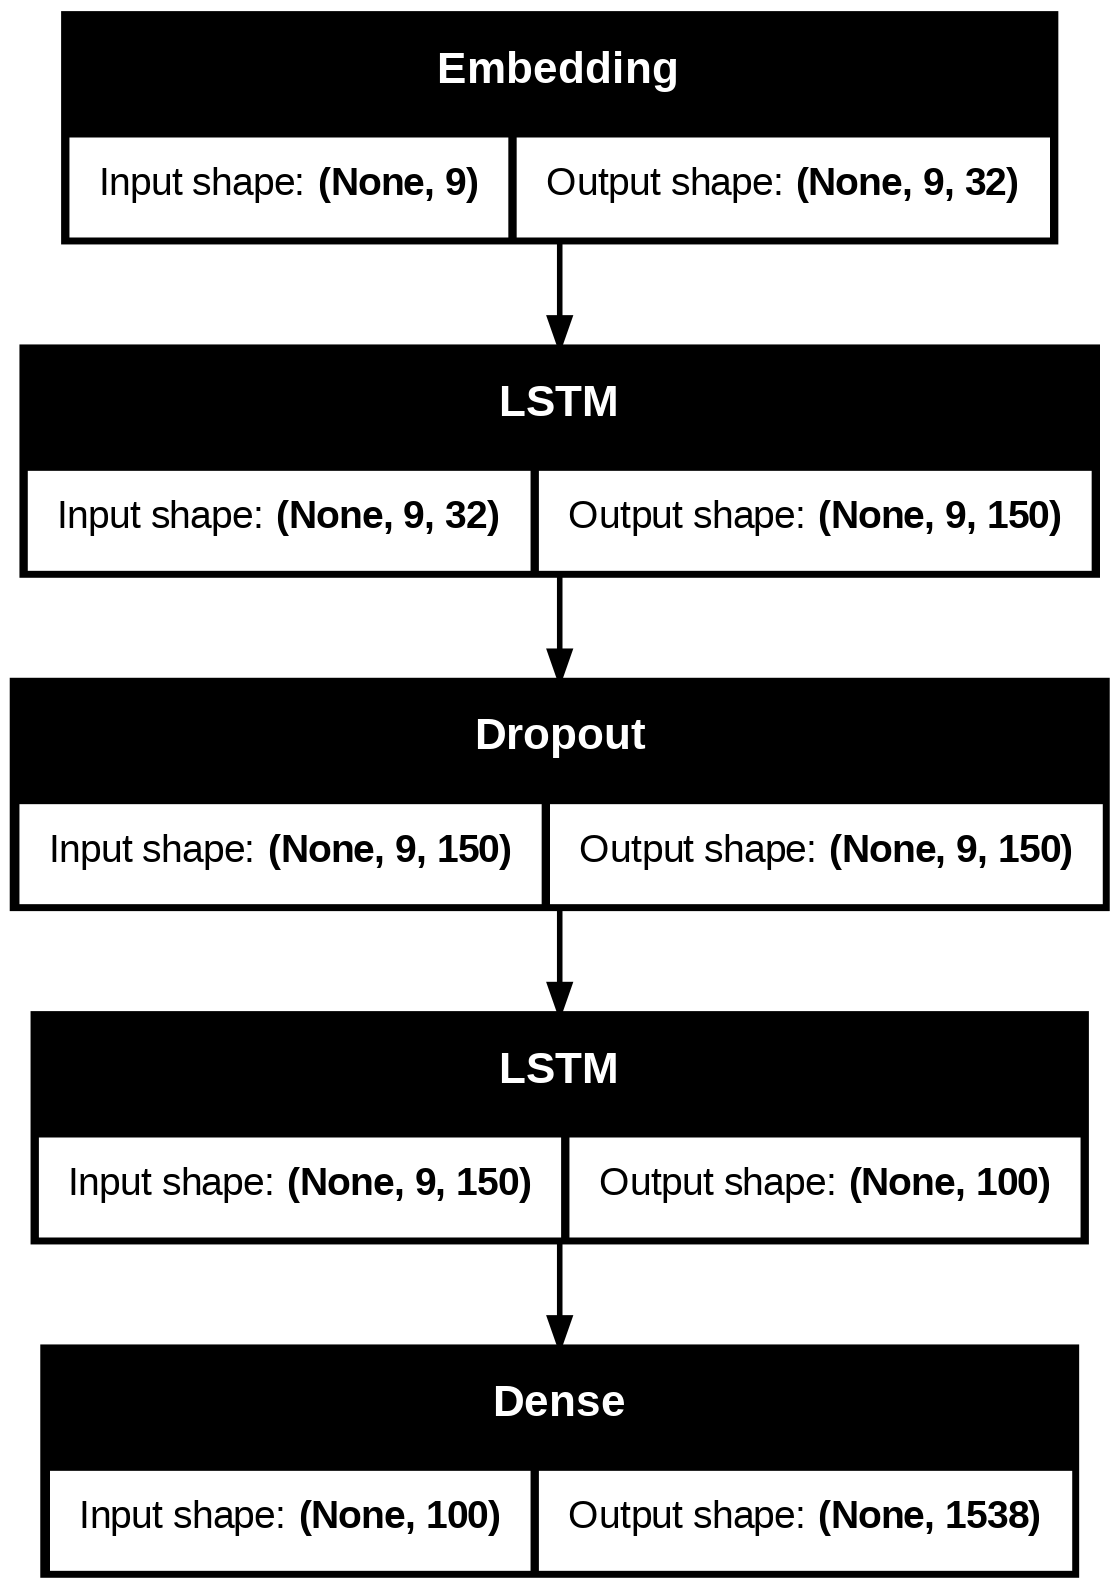

In [13]:
plot_model(model, show_shapes=True)

In [14]:
def gerar_texto(model, tokenizer, seed_text, max_sequence_len, next_words=50):
    """
    Gera texto com um modelo LSTM baseado em seed_text.

    Parâmetros:
    - model: o modelo LSTM treinado.
    - tokenizer: o tokenizer usado para indexar palavras.
    - seed_text: string inicial para começar a geração.
    - max_sequence_len: número máximo de palavras que o modelo aceita.
    - next_words: número de palavras a serem geradas.

    Retorna:
    - Texto gerado como string.
    """
    for _ in range(next_words):
        # Converte o seed_text para uma sequência numérica
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        #print(token_list)
        # Limita o token_list ao tamanho máximo especificado
        token_list = token_list[-(max_sequence_len - 1):]
        #print(token_list)
        # Realiza padding para que o token_list tenha o comprimento correto
        token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre')
        print(token_list)
        # Faz a previsão da próxima palavra
        predicted = np.argmax(model.predict(token_list, verbose=0), axis=-1)

        # Converte o índice previsto de volta para uma palavra
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        # Adiciona a palavra prevista ao seed_text
        seed_text += " " + output_word

    return seed_text

In [15]:
seed_text = "talvez"
texto_gerado = gerar_texto(model, tokenizer, seed_text, max_sequence_len = 10, next_words=20)
print(texto_gerado)

[[   0    0    0    0    0    0    0    0 1478]]
[[   0    0    0    0    0    0    0 1478   78]]
[[   0    0    0    0    0    0 1478   78  105]]
[[   0    0    0    0    0 1478   78  105 1479]]
[[   0    0    0    0 1478   78  105 1479    1]]
[[   0    0    0 1478   78  105 1479    1    5]]
[[   0    0 1478   78  105 1479    1    5  631]]
[[   0 1478   78  105 1479    1    5  631   49]]
[[1478   78  105 1479    1    5  631   49  160]]
[[  78  105 1479    1    5  631   49  160    6]]
[[ 105 1479    1    5  631   49  160    6   31]]
[[1479    1    5  631   49  160    6   31  658]]
[[  1   5 631  49 160   6  31 658  12]]
[[  5 631  49 160   6  31 658  12 241]]
[[631  49 160   6  31 658  12 241  28]]
[[ 49 160   6  31 658  12 241  28 616]]
[[160   6  31 658  12 241  28 616 659]]
[[  6  31 658  12 241  28 616 659 252]]
[[ 31 658  12 241  28 616 659 252   6]]
[[658  12 241  28 616 659 252   6 160]]
talvez até lhe conquiste que o emboscou ainda antigo e te ouve em novo dos carregando chamad

In [16]:
seed_text = "é difícil"
texto_gerado = gerar_texto(model, tokenizer, seed_text, max_sequence_len = 10, next_words=10)
print(texto_gerado)

[[  0   0   0   0   0   0   0   7 203]]
[[  0   0   0   0   0   0   7 203 487]]
[[  0   0   0   0   0   7 203 487  40]]
[[  0   0   0   0   7 203 487  40  19]]
[[   0    0    0    7  203  487   40   19 1015]]
[[   0    0    7  203  487   40   19 1015   11]]
[[   0    7  203  487   40   19 1015   11   67]]
[[   7  203  487   40   19 1015   11   67   64]]
[[ 203  487   40   19 1015   11   67   64    7]]
[[ 487   40   19 1015   11   67   64    7  311]]
é difícil defender ao terra gorda mais ele coisa é largo o


In [17]:
seed_text = "morte"
texto_gerado = gerar_texto(model, tokenizer, seed_text, max_sequence_len =10, next_words=10)
print(texto_gerado)

[[ 0  0  0  0  0  0  0  0 36]]
[[  0   0   0   0   0   0   0  36 427]]
[[  0   0   0   0   0   0  36 427  79]]
[[  0   0   0   0   0  36 427  79 223]]
[[   0    0    0    0   36  427   79  223 1277]]
[[   0    0    0   36  427   79  223 1277  229]]
[[   0    0   36  427   79  223 1277  229 1450]]
[[   0   36  427   79  223 1277  229 1450   67]]
[[  36  427   79  223 1277  229 1450   67  369]]
[[ 427   79  223 1277  229 1450   67  369  972]]
morte existe essa profissão conversa camisa tarde ele tinha contigo feito


In [18]:
seed_text = "mas diga me"
texto_gerado = gerar_texto(model, tokenizer, seed_text, max_sequence_len = 10, next_words=10)
print(texto_gerado)

[[ 0  0  0  0  0  0 18 48 21]]
[[ 0  0  0  0  0 18 48 21 62]]
[[  0   0   0   0  18  48  21  62 208]]
[[  0   0   0  18  48  21  62 208 780]]
[[  0   0  18  48  21  62 208 780   8]]
[[  0  18  48  21  62 208 780   8  60]]
[[ 18  48  21  62 208 780   8  60   4]]
[[ 48  21  62 208 780   8  60   4 128]]
[[ 21  62 208 780   8  60   4 128  40]]
[[ 62 208 780   8  60   4 128  40 354]]
mas diga me retirante fácil caroá não sei a semente ao filhos ficou


In [19]:
seed_text = "pouco"
texto_gerado = gerar_texto(model, tokenizer, seed_text, max_sequence_len =10, next_words=10)
print(texto_gerado)

[[ 0  0  0  0  0  0  0  0 65]]
[[  0   0   0   0   0   0   0  65 427]]
[[  0   0   0   0   0   0  65 427   5]]
[[  0   0   0   0   0  65 427   5   1]]
[[  0   0   0   0  65 427   5   1 770]]
[[  0   0   0  65 427   5   1 770 208]]
[[  0   0  65 427   5   1 770 208  67]]
[[  0  65 427   5   1 770 208  67  64]]
[[ 65 427   5   1 770 208  67  64  74]]
[[427   5   1 770 208  67  64  74  28]]
pouco existe o que lavrar fácil ele coisa chão dos fio


In [20]:
seed_text = "ao menos"
texto_gerado = gerar_texto(model, tokenizer, seed_text, max_sequence_len=10, next_words=10)
print(texto_gerado)

[[ 0  0  0  0  0  0  0 40 69]]
[[  0   0   0   0   0   0  40  69 464]]
[[   0    0    0    0    0   40   69  464 1033]]
[[   0    0    0    0   40   69  464 1033  328]]
[[   0    0    0   40   69  464 1033  328    2]]
[[   0    0   40   69  464 1033  328    2  181]]
[[   0   40   69  464 1033  328    2  181  999]]
[[  40   69  464 1033  328    2  181  999    6]]
[[  69  464 1033  328    2  181  999    6  485]]
[[ 464 1033  328    2  181  999    6  485 1191]]
ao menos aos deste setor de cá cama e coberta lento vivia


In [21]:
seed_text = "em vossa"
texto_gerado = gerar_texto(model, tokenizer, seed_text, max_sequence_len = 10, next_words=10)
print(texto_gerado)

[[  0   0   0   0   0   0   0  12 260]]
[[   0    0    0    0    0    0   12  260 1317]]
[[   0    0    0    0    0   12  260 1317 1318]]
[[   0    0    0    0   12  260 1317 1318   65]]
[[   0    0    0   12  260 1317 1318   65   44]]
[[   0    0   12  260 1317 1318   65   44   43]]
[[   0   12  260 1317 1318   65   44   43  123]]
[[  12  260 1317 1318   65   44   43  123  179]]
[[ 260 1317 1318   65   44   43  123  179   68]]
[[1317 1318   65   44   43  123  179   68    5]]
em vossa prosa entretida pouco ou melhor severina dar água o gorjetas


In [22]:
seed_text = "pescados"
texto_gerado = gerar_texto(model, tokenizer, seed_text, max_sequence_len =10, next_words=6)
print(texto_gerado)

[[   0    0    0    0    0    0    0    0 1357]]
[[   0    0    0    0    0    0    0 1357   27]]
[[   0    0    0    0    0    0 1357   27  298]]
[[   0    0    0    0    0 1357   27  298  157]]
[[   0    0    0    0 1357   27  298  157   28]]
[[   0    0    0 1357   27  298  157   28 1082]]
pescados por esses mangues dos bangüezeiros imperial


In [23]:
seed_text = "há"
texto_gerado = gerar_texto(model, tokenizer, seed_text, max_sequence_len =10, next_words=20)
print(texto_gerado)

[[ 0  0  0  0  0  0  0  0 32]]
[[  0   0   0   0   0   0   0  32 810]]
[[  0   0   0   0   0   0  32 810 811]]
[[  0   0   0   0   0  32 810 811  55]]
[[  0   0   0   0  32 810 811  55   8]]
[[  0   0   0  32 810 811  55   8 623]]
[[  0   0  32 810 811  55   8 623   5]]
[[  0  32 810 811  55   8 623   5 264]]
[[ 32 810 811  55   8 623   5 264   8]]
[[810 811  55   8 623   5 264   8  44]]
[[811  55   8 623   5 264   8  44 561]]
[[ 55   8 623   5 264   8  44 561  64]]
[[  8 623   5 264   8  44 561  64 234]]
[[623   5 264   8  44 561  64 234  89]]
[[  5 264   8  44 561  64 234  89 972]]
[[264   8  44 561  64 234  89 972 370]]
[[  8  44 561  64 234  89 972 370 241]]
[[ 44 561  64 234  89 972 370 241   2]]
[[561  64 234  89 972 370 241   2 241]]
[[ 64 234  89 972 370 241   2 241  28]]
há poucos engenhos já não lavra o mataram não ou franzina coisa serviço trabalhar contigo plantar novo de novo dos riba


In [24]:
seed_text = "os políticos dos"
texto_gerado = gerar_texto(model, tokenizer, seed_text, max_sequence_len =10, next_words=20)
print(texto_gerado)

[[   0    0    0    0    0    0   24 1080   28]]
[[   0    0    0    0    0   24 1080   28 1081]]
[[   0    0    0    0   24 1080   28 1081   64]]
[[   0    0    0   24 1080   28 1081   64   10]]
[[   0    0   24 1080   28 1081   64   10 1155]]
[[   0   24 1080   28 1081   64   10 1155 1156]]
[[  24 1080   28 1081   64   10 1155 1156  449]]
[[1080   28 1081   64   10 1155 1156  449  168]]
[[  28 1081   64   10 1155 1156  449  168   11]]
[[1081   64   10 1155 1156  449  168   11    8]]
[[  64   10 1155 1156  449  168   11    8   48]]
[[  10 1155 1156  449  168   11    8   48    4]]
[[1155 1156  449  168   11    8   48    4 1181]]
[[1156  449  168   11    8   48    4 1181  216]]
[[ 449  168   11    8   48    4 1181  216    4]]
[[ 168   11    8   48    4 1181  216    4   19]]
[[  11    8   48    4 1181  216    4   19    6]]
[[   8   48    4 1181  216    4   19    6  189]]
[[  48    4 1181  216    4   19    6  189  153]]
[[   4 1181  216    4   19    6  189  153  270]]
os políticos dos ban